In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [16]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [18]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [19]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [20]:
features = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
X = train_data[features].copy()
Y = train_data["Survived"].values.reshape(-1,1)

#Fills up empty values (NaN) with median age
X.fillna({"Age": X["Age"].median()}, inplace=True) 
#Fills up empty values (NaN) with most common port
X.fillna({"Embarked": X["Embarked"].mode()[0]}, inplace=True)

In [21]:
def one_hot_encode(df, column, drop_first=True):
    unique_values = df[column].unique()
    if drop_first:
        unique_values = unique_values[1:] #Drops first type to reduce reduncy
    for val in unique_values: #creates columns for every val
        df[f"{column}_{val}"] = (df[column] == val).astype(int) #Checks for val in column and converts bool to 0 or 1
    df.drop(columns=[column], inplace=True) #Drop original column
    return df
def normalize_func(df, columns): 
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        if (std <= 0): std = 1
        df[col] = (df[col]-mean) / std  #Normalization by Standardization
    return df    

In [22]:
X = one_hot_encode(X, "Sex", True)
X = one_hot_encode(X, "Embarked", True)
X = normalize_func(X, ["Age","Fare"])
X = X.values  #X becomes a NumPy array, (row,col) = (samples,features)

In [23]:
split_id = int(0.8 * X.shape[0])  #Finding ID where split is 80:20
X_Train = X[:split_id]
X_Val = X[split_id:]
Y_Train = Y[:split_id]
Y_Val = Y[split_id:]

In [24]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
    
def initialize_params(m_features, seed=None):
    if seed: np.random.seed(seed)
    w = np.random.randn(m_features,1) * 0.01 #random small numbers one col vector
    b = 0.0
    return w,b
    
def forward(X,w,b):
    z = np.dot(X, w) + b #No need to transpose as X is a NumPy array
    y_hat = sigmoid(z)
    return z,y_hat

def compute_cost(y, y_hat):
    n = y.shape[0]
    cost = -(1/n) * np.sum(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))   #can add eps = 1e-15 to avoid log(0)
    return cost

def compute_gradients(X,y,y_hat):
    n = X.shape[0]
    dw = (1/n) * np.dot(X.T, (y_hat-y))
    db = (1/n) * np.sum(y_hat-y)
    return dw,db

def update_params(w,b,dw,db,lr):
    w -= lr * dw
    b -= lr * db
    return w,b

def train(X,y,lr,n_epochs,X_val=None,y_val=None):
    n,m = X.shape
    w,b = initialize_params(m,seed=38)  #Seed number 38 choses for consistent random numbers
    train_costs,val_costs = [],[]
    
    for epoch in range(n_epochs):
        _,y_hat = forward(X,w,b)
        cost = compute_cost(y,y_hat)
        dw,db = compute_gradients(X,y,y_hat)
        w,b = update_params(w,b,dw,db,lr)
        
        train_costs.append(cost)
        if X_val is not None and y_val is not None:  #Tracking Validation Loss
            y_val_hat = predict_proba(X_val,w,b)
            val_costs.append(compute_cost(y_val,y_val_hat))    
    return w,b,train_costs,val_costs

def predict_proba(X,w,b):
    z = np.dot(X,w) + b
    return sigmoid(z)

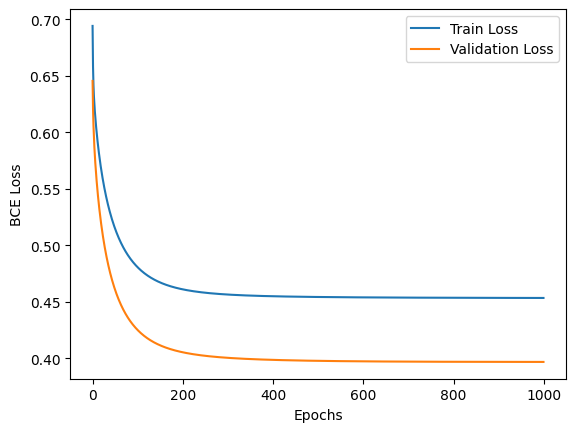

In [25]:
import matplotlib.pyplot as plt

w,b,train_costs,val_costs = train(X_Train,Y_Train,lr=0.22,n_epochs=1000,X_val=X_Val,y_val=Y_Val)

plt.plot(train_costs,label="Train Loss")
plt.plot(val_costs,label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score
Y_Val_predict = (predict_proba(X_Val,w,b)>0.5).astype(int)
print("Validation Accuracy for Scratch Model:",accuracy_score(Y_Val,Y_Val_predict))

from sklearn.linear_model import LogisticRegression
tm = LogisticRegression(max_iter=1000)
tm.fit(X_Train,Y_Train.ravel())
Y_Val_predict_tm = tm.predict(X_Val)
print("Validation Accuracy for SKLearn:",accuracy_score(Y_Val,Y_Val_predict_tm))

Validation Accuracy for Scratch Model: 0.8379888268156425
Validation Accuracy for SKLearn: 0.8324022346368715


In [27]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
X_test = test_df[features].copy()

#X_test["Age"].fillna(X_test["Age"].median(), inplace=True)
X_test.fillna({"Age": X_test["Age"].median()}, inplace=True) 
#X_test["Fare"].fillna(X_test["Fare"].median(), inplace=True)
X_test.fillna({"Fare": X_test["Fare"].median()}, inplace=True)
X_test = one_hot_encode(X_test, "Sex", drop_first=True)
X_test = one_hot_encode(X_test, "Embarked", drop_first=True)
X_test = normalize_func(X_test, ["Age", "Fare"])
X_test = X_test.values

w, b, _, _ = train(X, Y, lr=0.22, n_epochs=1000)

y_test_pred = (predict_proba(X_test, w, b) > 0.5).astype(int)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": y_test_pred.flatten()
})
submission.to_csv("submission.csv", index=False)
from IPython.display import FileLink
FileLink("submission.csv")

/kaggle/working/submission.csv